# NBME / Fine-tuning DeBERTa | TensorFlow


This notebook contains complete code to fine-tune **DeBERTa** to develop an automated way of identifying the relevant features within each patient note on dataset of  text data presented from the USMLE® Step 2 Clinical Skills examination, a medical licensure exam. In addition to training a model using  **Tensorflow**, you will learn how to preprocess text into an appropriate format.


**In this notebook, you will:**
* have a quick overview at Transformers and DeBERTa model.
* Load dataset.
* Load Tokenizer and prepare the data.
* Load  DeBERTa and build your own model.
* Train your own model, fine-tuning DeBERTa as part of that
* Save your model and use it.


## Transformers
Transformer models are used to solve all kinds of  NLP (**N**atural **L**anguage **P**rocessing ) tasks, and The Transformers library provides the functionality to create and use those models.The Transformer architecture was introduced in 2017 and the original research  focused  on translation tasks, after that several models were  introducted such as (GPT, BERT,GPT-2,DistilBERT, BART, and  GPT-3) [[Ref]](https://huggingface.co/course/chapter1/4?fw=tf)

## DeBERTa Model
**DeBERTa** (**D**ecoding-**e**nhanced **BERT** with disentangled **a**ttention) improves the BERT and RoBERTa models using two novel techniques, the first is disentangled attention mechanism and the Second is enhanced mask decoder [[Ref]](https://www.microsoft.com/en-us/research/publication/deberta-decoding-enhanced-bert-with-disentangled-attention-2/).

DeBERTa outperforms BERT and RoBERTa on majority of NLU(**N**atural **L**anguage **U**nderstanding) tasks with 80GB training data [[Ref]](https://github.com/microsoft/DeBERTa).

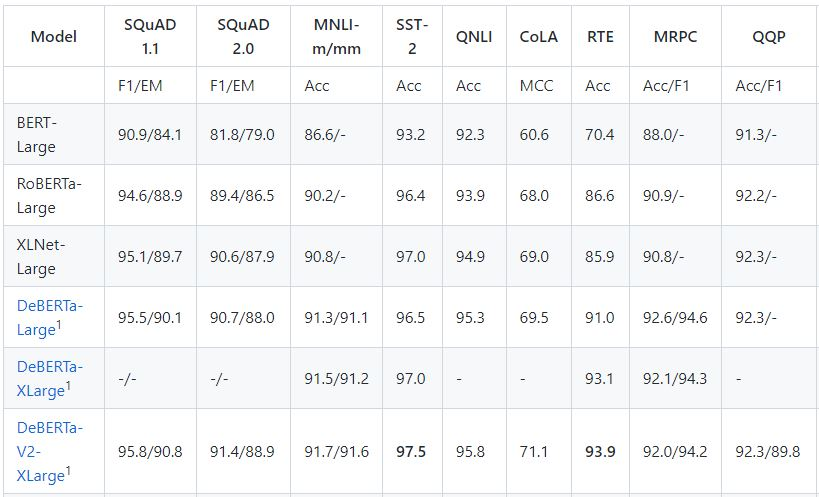



## Transformers Pipeline
All NLP tasks use Transformers pipeline that contains three  steps.
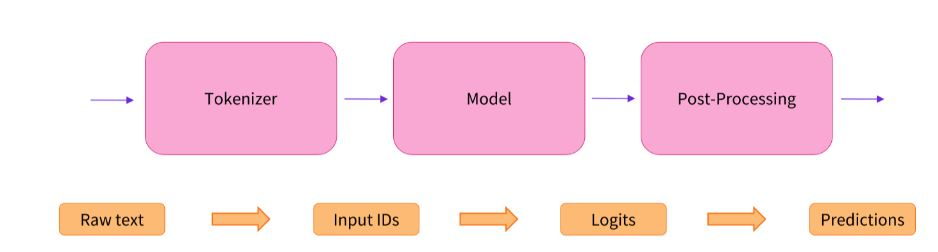

### 1- Tokenizer (Preprocessing):
Transformer models can’t process raw text(Like other neural networks) directly, we have  to convert the text inputs into numbers. we use a tokenizer to do that. All preprocessing need to done as same way the model pretrained, so we use the ***AutoTokenizer*** class and its ***from_pretrained()*** method with the checkpoint name of our model. After using the checkpoint of our model the tokenizer of model will automatically be downloaded.

### 2- Model:
Tranformers provides ***TFAutoModel*** class that also has a ***from_pretrained()*** method to download pretrained model in same way we do for tokenizer.

### 3- Postprocessing:
The outputs we get from our model don't make sense, they are logits (not probabilities), to convert them to probabilities we need to pass them through a Softmax layer.

## Imports

***AutoConfig*** is a  configuration class that will be instantiated as one of the configuration 
classes of the library when created with the ***from_pretrained()*** class method.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import os
import ast
import spacy
import random
import itertools
import matplotlib.pyplot as plt
from typing import List, Tuple

import tensorflow as tf
import tensorflow_addons as tfa



from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoConfig, TFAutoModel

## Config

In [ ]:
# ---------- Model ---------- 
MODEL_NAME = 'microsoft/deberta-base'
TOKENIZER_PATH = f'{MODEL_NAME}_tokenizer'
MAX_LEN = 512

# ---------- Training ----------
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 2e-5
CLIP_NORM = 1000

# ---------- Dataset ----------
seed=42
n_fold=5
fold=4

debug=False
if debug:
    EPOCHS = 3

## Data Loading

### train.csv

In [ ]:
train = pd.read_csv('../input/nbme-score-clinical-patient-notes/train.csv')
train['annotation'] = train['annotation'].apply(ast.literal_eval) # Construct an object from a string
train['location'] = train['location'].apply(ast.literal_eval) # Construct an object from a string
print(f"train.shape: {train.shape}")
train.head()

### features.csv

In [ ]:
features = pd.read_csv('../input/nbme-score-clinical-patient-notes/features.csv')
print(f"features.shape: {features.shape}")
features.head()

### patient_notes.csv

In [ ]:
patient_notes = pd.read_csv('../input/nbme-score-clinical-patient-notes/patient_notes.csv')
print(f"patient_notes.shape: {patient_notes.shape}")
patient_notes.head()

### Merging

In [ ]:
train = train.merge(features, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes, on=['pn_num', 'case_num'], how='left')
train['annotation_length'] = train['annotation'].apply(len)
print(f"train.shape: {train.shape}")
train.head()

In [ ]:
if debug:
    train = train.sample(n=500, random_state=0).reset_index(drop=True)

## Annotations Visualization

In [ ]:
idx=1#5910

locations = train.loc[idx,'location']
pn_history= train.loc[idx,'pn_history']

start_pos = []
end_pos = []

for location in locations:
    for loc in [s.split() for s in location.split(';')]:
        start_pos.append(int(loc[0]))
        end_pos.append(int(loc[1]))


ents = []
for i in range(len(start_pos)):
    ents.append({
        'start': int(start_pos[i]), 
        'end' : int(end_pos[i]),
        "label" : "Annotation"
    })
doc = {
    'text' : pn_history,
    "ents" : ents
}

colors = {"Annotation": "linear-gradient(0deg, #888, #eeaaaa)"} 
options = {"colors": colors}
spacy.displacy.render(doc, style="ent", options=options , manual=True, jupyter=True);

## CV split

In [ ]:
Fold = GroupKFold(n_splits=n_fold)
groups = train['pn_num'].values
for n, (train_index, val_index) in enumerate(Fold.split(train, train['annotation_length'], groups)):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
print(train.groupby('fold').size())

valid=train[train.fold==fold]
train=train[train.fold!=fold]

train, valid = train_test_split(
    train[['pn_history', 'feature_text','annotation_length', 'location']],
    test_size=0.25,
    random_state=seed
)

## Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.save_pretrained(f'{TOKENIZER_PATH}')

config = AutoConfig.from_pretrained(MODEL_NAME)
config.save_pretrained(f'{TOKENIZER_PATH}')

## Preprocess the data

In [ ]:
# ------------------------- prepare_location ------------------------------
def prepare_location(locations: str) -> List[Tuple[int]]:
    """
    This function returns list of tuples of locations
    """
    location_tuple_list = []
    for location in locations:
        for loc in [s.split() for s in location.split(';')]:
            start, end = int(loc[0]), int(loc[1])
            location_tuple_list.append((start, end))
    
    return location_tuple_list
# ------------------------- prepare_input ------------------------------
def prepare_input(pn_history: str, feature_text: str):
    """
    This function tokenizes pn_history and feature text and
    returns numpy array of input_ids and attention_masks
    """
    tokens = tokenizer(
        pn_history,
        feature_text,
        max_length=MAX_LEN,
        padding="max_length",
        add_special_tokens=True,
    )
    
    input_ids = tokens['input_ids']
    attention_mask = tokens["attention_mask"]
    return np.array(input_ids), np.array(attention_mask)
# ------------------------- prepare_labels ------------------------------
# Thanks yasufuminakama 
# https://www.kaggle.com/yasufuminakama/nbme-deberta-base-baseline-train
def prepare_labels(pn_history, annotation_length, location_list):
    """
    This function creates labels with are vectors of zeros (no entity)
    and ones (entity)
    """
    tokenized = tokenizer(
        pn_history,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding="max_length",
        return_offsets_mapping=True
    )
    offset_mapping = tokenized["offset_mapping"]
    label = np.zeros(len(offset_mapping))
    if annotation_length != 0:
        locations = prepare_location(location_list)
        for location in locations:
            start_idx, end_idx = -1, -1
            start, end = location
            for idx in range(len(offset_mapping)):
                if (start_idx == -1) & (start < offset_mapping[idx][0]):
                    start_idx = idx - 1
                if (end_idx == -1) & (end <= offset_mapping[idx][1]):
                    end_idx = idx + 1
            if start_idx == -1:
                start_idx = end_idx
            if (start_idx != -1) & (end_idx != -1):
                label[start_idx:end_idx] = 1
            
    return np.array(label)

In [ ]:
def create_data(dataframe: pd.DataFrame,train=True):
    pn_history = dataframe["pn_history"].values
    feature_text = dataframe["feature_text"].values
    if train:
        annotation_length = dataframe['annotation_length'].values
        location = dataframe['location'].values
    input_ids = []
    attention_mask = []
    labels = []

    for i in range(len(dataframe)):
        inputs, masks = prepare_input(pn_history[i], feature_text[i])
        input_ids.append(inputs)
        attention_mask.append(masks)
        if train:
            lbls = prepare_labels(pn_history[i], annotation_length[i], location[i])
            labels.append(lbls)
    return {"input_ids":input_ids,"attention_mask":attention_mask}, labels
    
train_data, train_labels = create_data(train,train=True)
val_data, val_labels = create_data(valid,train=True)

## Dataset

In [ ]:
train_data_X =(np.asarray(train_data['input_ids']),np.asarray(train_data['attention_mask']))          
train_data_Y =np.asarray(train_labels).ravel()

valid_data = ((np.asarray(val_data['input_ids']),
              np.asarray(val_data['attention_mask']),
             ),np.asarray(val_labels).ravel())

## Build Model

In [ ]:
def scheduler(epoch):
    learning_rate = LEARNING_RATE
    if epoch == 0:
        return learning_rate * 1
    else:
        return learning_rate * (0.7**epoch)

plt.plot([scheduler(e) for e in range(EPOCHS)])

In [ ]:
# callbacks
model_save = tf.keras.callbacks.ModelCheckpoint(
    f'./model_deberta_fold{fold}.h5', 
    save_best_only = True, 
    save_weights_only = True,
    monitor = 'val_loss', 
    mode = 'min', verbose = 1
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-5, 
    patience=5, 
    verbose=1,
    mode='auto', 
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=2, 
    mode='auto', 
    min_delta=0.001,
    verbose = 1
)
#reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
# metrics
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.f1 = tfa.metrics.F1Score(num_classes=2, average='micro', threshold=0.50)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, (-1,MAX_LEN))
        y_pred = tf.reshape(y_pred, (-1,MAX_LEN))
        self.f1.update_state(y_true, y_pred)
        
    def reset_state(self):
        self.f1.reset_state()
    
    def result(self):
        return self.f1.result()
    
metrics = [
    F1Score()
]

In [ ]:
# create_model
def create_model() -> tf.keras.Model:
    input_tokens = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32)

    config = AutoConfig.from_pretrained(MODEL_NAME, output_hidden_states=True)
    backbone = TFAutoModel.from_pretrained(MODEL_NAME, config=config)
    #backbone = TFAutoModel.from_pretrained(f'{MODEL_NAME})
    backbone.save_pretrained(f'{MODEL_NAME}/model')

    out = backbone(input_tokens, attention_mask=attention_mask)[0]
    out = tf.keras.layers.Dropout(0.2)(out)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(out)

    return tf.keras.Model(inputs=[input_tokens, attention_mask], outputs=out)

model = create_model()
model.summary()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, clipnorm=CLIP_NORM)
loss = tf.keras.losses.BinaryCrossentropy(reduction="none")
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

## Training

In [ ]:
train_data_X =(np.asarray(train_data['input_ids']),np.asarray(train_data['attention_mask']))          
train_data_Y =np.asarray(train_labels)

valid_data = ((np.asarray(val_data['input_ids']),
              np.asarray(val_data['attention_mask']),
             ),np.asarray(val_labels))

In [ ]:
xx=np.asarray(train_data['input_ids'])
print(xx.shape)

In [ ]:
history=model.fit(
            train_data_X,
            train_data_Y, 
            epochs = EPOCHS,
            shuffle=True,
            batch_size = BATCH_SIZE,
            validation_data= valid_data,
            callbacks = [model_save, early_stop, reduce_lr]
)

## Evaluation
### Loss curve

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='val_loss')
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='loss')
plt.title('loss'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

## F1 curve

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_f1'],label='val_f1')
plt.plot(range(history.epoch[-1]+1),history.history['f1'],label='f1')
plt.title('F1'); plt.xlabel('Epoch'); plt.ylabel('f1');plt.legend(); 
plt.show()

## OOF

In [ ]:
preds_valid = model.predict((np.asarray(val_data['input_ids']),
                            np.asarray(val_data['attention_mask']),))
preds_valid = preds_valid.reshape(len(valid), MAX_LEN)
valid[[i for i in range(MAX_LEN)]] = preds_valid
print(valid.shape) 
valid.to_pickle(f'./oof_fold{fold}.pkl')

## Inference

In [ ]:
test = pd.read_csv('../input/nbme-score-clinical-patient-notes/test.csv')
test = test.merge(features, on=['feature_num', 'case_num'], how='left')
test = test.merge(patient_notes, on=['pn_num', 'case_num'], how='left')
test.head()

## Test Dataset

In [ ]:
test_data, test_labels = create_data(test,train=False)

## Functions

In [ ]:
# Thanks yasufuminakama 
# https://www.kaggle.com/yasufuminakama/nbme-deberta-base-baseline-train

def get_char_probs(texts, predictions, tokenizer):
    results = [np.zeros(len(t)) for t in texts]
    for i, (text, prediction) in enumerate(zip(texts, predictions)):
        encoded = tokenizer(text, 
                            add_special_tokens=True,
                            return_offsets_mapping=True)
        for idx, (offset_mapping, pred) in enumerate(zip(encoded['offset_mapping'], prediction)):
            start = offset_mapping[0]
            end = offset_mapping[1]
            results[i][start:end] = pred
    return results


def get_results(char_probs, th=0.5):
    results = []
    for char_prob in char_probs:
        result = np.where(char_prob >= th)[0] + 1
        result = [list(g) for _, g in itertools.groupby(result, key=lambda n, c=itertools.count(): n - next(c))]
        result = [f"{min(r)} {max(r)}" for r in result]
        result = ";".join(result)
        results.append(result)
    return results

In [ ]:
preds = model.predict((np.asarray(test_data['input_ids']),
                            np.asarray(test_data['attention_mask']),))
preds = preds.reshape(len(test), MAX_LEN)

In [ ]:
char_probs = get_char_probs(test['pn_history'].values, preds, tokenizer)
results = get_results(char_probs, th=0.5)

## Submission

In [ ]:
submission = pd.read_csv('../input/nbme-score-clinical-patient-notes/sample_submission.csv')
submission['location'] = results
display(submission.head())
submission[['id', 'location']].to_csv('submission.csv', index=False)

## References

1. https://huggingface.co/course/chapter1/4?fw=tf
1. https://www.microsoft.com/en-us/research/publication/deberta-decoding-enhanced-bert-with-disentangled-attention-2/
1. https://github.com/microsoft/DeBERTa
1. https://huggingface.co/course/chapter1/1
1. https://www.kaggle.com/yasufuminakama/nbme-deberta-base-baseline-train
1. https://www.kaggle.com/huchlatymon/nbme-eda-deberta-train-cv-0-85
1. https://colab.research.google.com/drive/1pH9NKhAHT40ygOOf4bwld8j221r9SRq_?usp=sharing#scrollTo=SzCwE_mHkPxj
1. https://tensorexamples.com/2020/07/27/Using-the-tf.data.Dataset.html